## Interactive subspaces

This notebook let you to gaze subspaces we learn with an interactive UMAP.

In [1]:
import json
import torch
import pandas as pd
import altair as alt
from umap import UMAP
from plotnine import *

In [2]:
def load_jsonl(filepath):
    """Example JSONL loading function."""
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return data

def get_genre(metadata_entry):
    """Returns the genre string ('text', 'code', or 'math')."""
    concept_name = metadata_entry['concept']
    return metadata_entry['concept_genres_map'][concept_name][0]

In [3]:
lsreft = torch.load("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_lsreft/train/LsReFT_weight.pt")
lsreft_metadata = load_jsonl("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_lsreft/train/metadata.jsonl")
assert lsreft.shape[0] == len(lsreft_metadata)

diffmean = torch.load("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_diffmean/train/DiffMean_weight.pt")
diffmean_metadata = load_jsonl("/nlp/scr/wuzhengx/pyreax/axbench/results/prod_2b_l20_concept16k_diffmean/train/metadata.jsonl")
assert diffmean.shape[0] == len(diffmean_metadata)
assert lsreft.shape[0] == diffmean.shape[0]

In [ ]:
umap_lsreft = UMAP(n_components=2, random_state=42).fit_transform(lsreft.float().numpy())
umap_diffmean = UMAP(n_components=2, random_state=42).fit_transform(diffmean.float().numpy())

In [6]:
df_lsreft = pd.DataFrame({
    'x': umap_lsreft[:, 0],
    'y': umap_lsreft[:, 1],
    'concept': [m['concept'] for m in lsreft_metadata],    # or any other field
    'genre':   [get_genre(m) for m in lsreft_metadata],
    'method':  'LsReFT'
})
df_diffmean = pd.DataFrame({
    'x': umap_diffmean[:, 0],
    'y': umap_diffmean[:, 1],
    'concept': [m['concept'] for m in diffmean_metadata],
    'genre':   [get_genre(m) for m in diffmean_metadata],
    'method':  'DiffMean'
})

In [ ]:
alt.data_transformers.disable_max_rows()

chart = (
    alt.Chart(df_all)
    .mark_circle(size=30)
    .encode(
        x=alt.X('x:Q'),
        y=alt.Y('y:Q'),
        color=alt.Color('genre:N', legend=alt.Legend(title="Genre")),
        tooltip=['concept:N', 'method:N', 'genre:N']  # fields that appear on hover
    )
    .interactive()  # Allows panning & zooming
)

chart  # Display in Jupyter

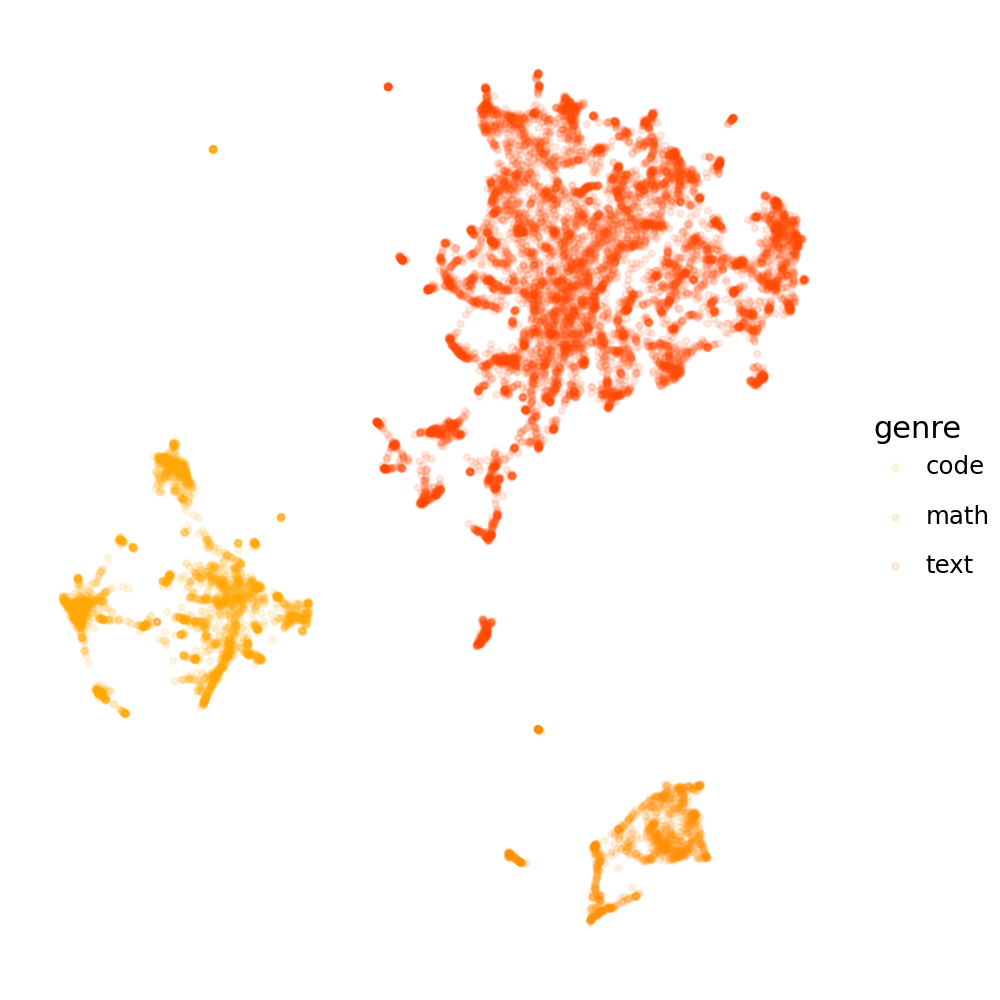

<Figure Size: (500 x 500)>

In [33]:
from plotnine import (
    ggplot, aes, geom_point, scale_color_manual, theme_minimal,
    theme, element_blank, element_text, element_rect, annotate
)

# Example custom orange palette for three genres:
# Feel free to tweak these hex codes to match your desired style
orange_palette = ["#FFA500", "#FF8C00", "#FF4500"]  # light to darker orange

plot = (
    ggplot(df_lsreft, aes(x="x", y="y", color="genre"))
    + geom_point(alpha=0.1, size=0.8)  # Slightly larger & more opaque
    + scale_color_manual(values=orange_palette)
    + theme_minimal()
    + theme(
        # Hide axis text and titles, remove grid
        axis_text=element_blank(),
        axis_title=element_blank(),
        panel_grid=element_blank(),
        # If you want to show a legend, remove or change legend_position
        legend_position="right",
        figure_size=(5, 5)
    )
)

plot
